# Analisis Big Data untuk Memetakan Prevalensi dan Faktor Risiko HIV

## 📊 INSIGHT & KESIMPULAN KOMPREHENSIF

**Tujuan:**
- Menggabungkan hasil EDA dan Modeling
- Menyajikan insight yang actionable
- Memberikan rekomendasi berdasarkan temuan
- Visualisasi insight yang komprehensif


In [1]:
# Import Library yang Diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import joblib

# Konfigurasi
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Library berhasil diimport!")
print(f"📅 Tanggal analisis insight: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ Library berhasil diimport!
📅 Tanggal analisis insight: 2025-11-25 13:37:58


## 1. Memuat Data dan Hasil Analisis


In [2]:
# Memuat dataset yang sudah dibersihkan
print("=" * 80)
print("📂 MEMUAT DATA UNTUK INSIGHT ANALYSIS")
print("=" * 80)

# Dataset utama
df_hiv = pd.read_csv('no_of_people_living_with_hiv_by_country_clean.csv')
df_hiv_clean = df_hiv[df_hiv['Count_median'] != 'na'].copy()
df_hiv_clean = df_hiv_clean[df_hiv_clean['Count_median'].notna()].copy()
df_hiv_clean['Count_median'] = pd.to_numeric(df_hiv_clean['Count_median'], errors='coerce')
df_hiv_clean = df_hiv_clean.dropna(subset=['Count_median'])

# Dataset tambahan
df_deaths = pd.read_csv('no_of_deaths_by_country_clean.csv')
df_deaths_clean = df_deaths[df_deaths['Count_median'] != 'na'].copy()
df_deaths_clean['Count_median'] = pd.to_numeric(df_deaths_clean['Count_median'], errors='coerce')
df_deaths_clean = df_deaths_clean.dropna(subset=['Count_median'])

# Dataset gabungan untuk modeling
try:
    modeling_df = pd.read_csv('hiv_merged_data.csv')
    print("✅ Dataset gabungan berhasil dimuat")
except:
    print("⚠️ Dataset gabungan tidak ditemukan, akan dibuat ulang")
    modeling_df = None

# Load model comparison jika ada
try:
    comparison_df = pd.read_csv('model_comparison_results.csv')
    print("✅ Hasil perbandingan model berhasil dimuat")
except:
    print("⚠️ Hasil perbandingan model tidak ditemukan")
    comparison_df = None

print(f"\n✅ Dataset HIV: {df_hiv_clean.shape}")
print(f"✅ Dataset Deaths: {df_deaths_clean.shape}")
if modeling_df is not None:
    print(f"✅ Dataset Modeling: {modeling_df.shape}")


📂 MEMUAT DATA UNTUK INSIGHT ANALYSIS
✅ Dataset gabungan berhasil dimuat
✅ Hasil perbandingan model berhasil dimuat

✅ Dataset HIV: (553, 7)
✅ Dataset Deaths: (400, 7)
✅ Dataset Modeling: (134, 4)


## 2. Insight Utama dari EDA


In [3]:
# Analisis Insight Utama dari EDA
print("=" * 80)
print("🔍 INSIGHT UTAMA DARI EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# 1. Statistik Global
total_cases = df_hiv_clean['Count_median'].sum()
avg_per_country = df_hiv_clean['Count_median'].mean()
median_cases = df_hiv_clean['Count_median'].median()
num_countries = df_hiv_clean['Country'].nunique()

print("\n📊 STATISTIK GLOBAL HIV/AIDS:")
print(f"   🌍 Total kasus HIV global: {total_cases:,.0f} orang")
print(f"   📈 Rata-rata per negara: {avg_per_country:,.0f} orang")
print(f"   📊 Median kasus: {median_cases:,.0f} orang")
print(f"   🗺️ Jumlah negara yang dianalisis: {num_countries}")

# 2. Top 10 Negara dengan Kasus Tertinggi
country_stats = df_hiv_clean.groupby('Country')['Count_median'].sum().sort_values(ascending=False)
top_10_countries = country_stats.head(10)

print("\n🔝 TOP 10 NEGARA DENGAN KASUS HIV TERTINGGI:")
for i, (country, cases) in enumerate(top_10_countries.items(), 1):
    percentage = (cases / total_cases) * 100
    print(f"   {i:2d}. {country:30s}: {cases:>12,.0f} kasus ({percentage:5.2f}%)")

# 3. Distribusi per WHO Region
region_stats = df_hiv_clean.groupby('WHO Region')['Count_median'].sum().sort_values(ascending=False)
print("\n🌍 DISTRIBUSI KASUS PER WHO REGION:")
for region, cases in region_stats.items():
    percentage = (cases / total_cases) * 100
    print(f"   - {region:25s}: {cases:>12,.0f} kasus ({percentage:5.2f}%)")

# 4. Tren Waktu
yearly_total = df_hiv_clean.groupby('Year')['Count_median'].sum().sort_index()
if len(yearly_total) > 1:
    print("\n📈 TREN WAKTU (Growth Rate):")
    for i in range(1, len(yearly_total)):
        prev_year = yearly_total.iloc[i-1]
        curr_year = yearly_total.iloc[i]
        growth_rate = ((curr_year - prev_year) / prev_year) * 100
        print(f"   {int(yearly_total.index[i-1])} → {int(yearly_total.index[i])}: {growth_rate:+.2f}%")


🔍 INSIGHT UTAMA DARI EXPLORATORY DATA ANALYSIS

📊 STATISTIK GLOBAL HIV/AIDS:
   🌍 Total kasus HIV global: 102,742,880 orang
   📈 Rata-rata per negara: 185,792 orang
   📊 Median kasus: 21,000 orang
   🗺️ Jumlah negara yang dianalisis: 140

🔝 TOP 10 NEGARA DENGAN KASUS HIV TERTINGGI:
    1. South Africa                  :   22,100,000 kasus (21.51%)
    2. Kenya                         :    6,300,000 kasus ( 6.13%)
    3. Nigeria                       :    6,100,000 kasus ( 5.94%)
    4. Mozambique                    :    5,840,000 kasus ( 5.68%)
    5. Zimbabwe                      :    5,500,000 kasus ( 5.35%)
    6. United Republic of Tanzania   :    5,200,000 kasus ( 5.06%)
    7. Uganda                        :    4,700,000 kasus ( 4.57%)
    8. Zambia                        :    4,010,000 kasus ( 3.90%)
    9. Malawi                        :    3,500,000 kasus ( 3.41%)
   10. Ethiopia                      :    2,710,000 kasus ( 2.64%)

🌍 DISTRIBUSI KASUS PER WHO REGION:
   - Africa

## 3. Visualisasi Insight EDA


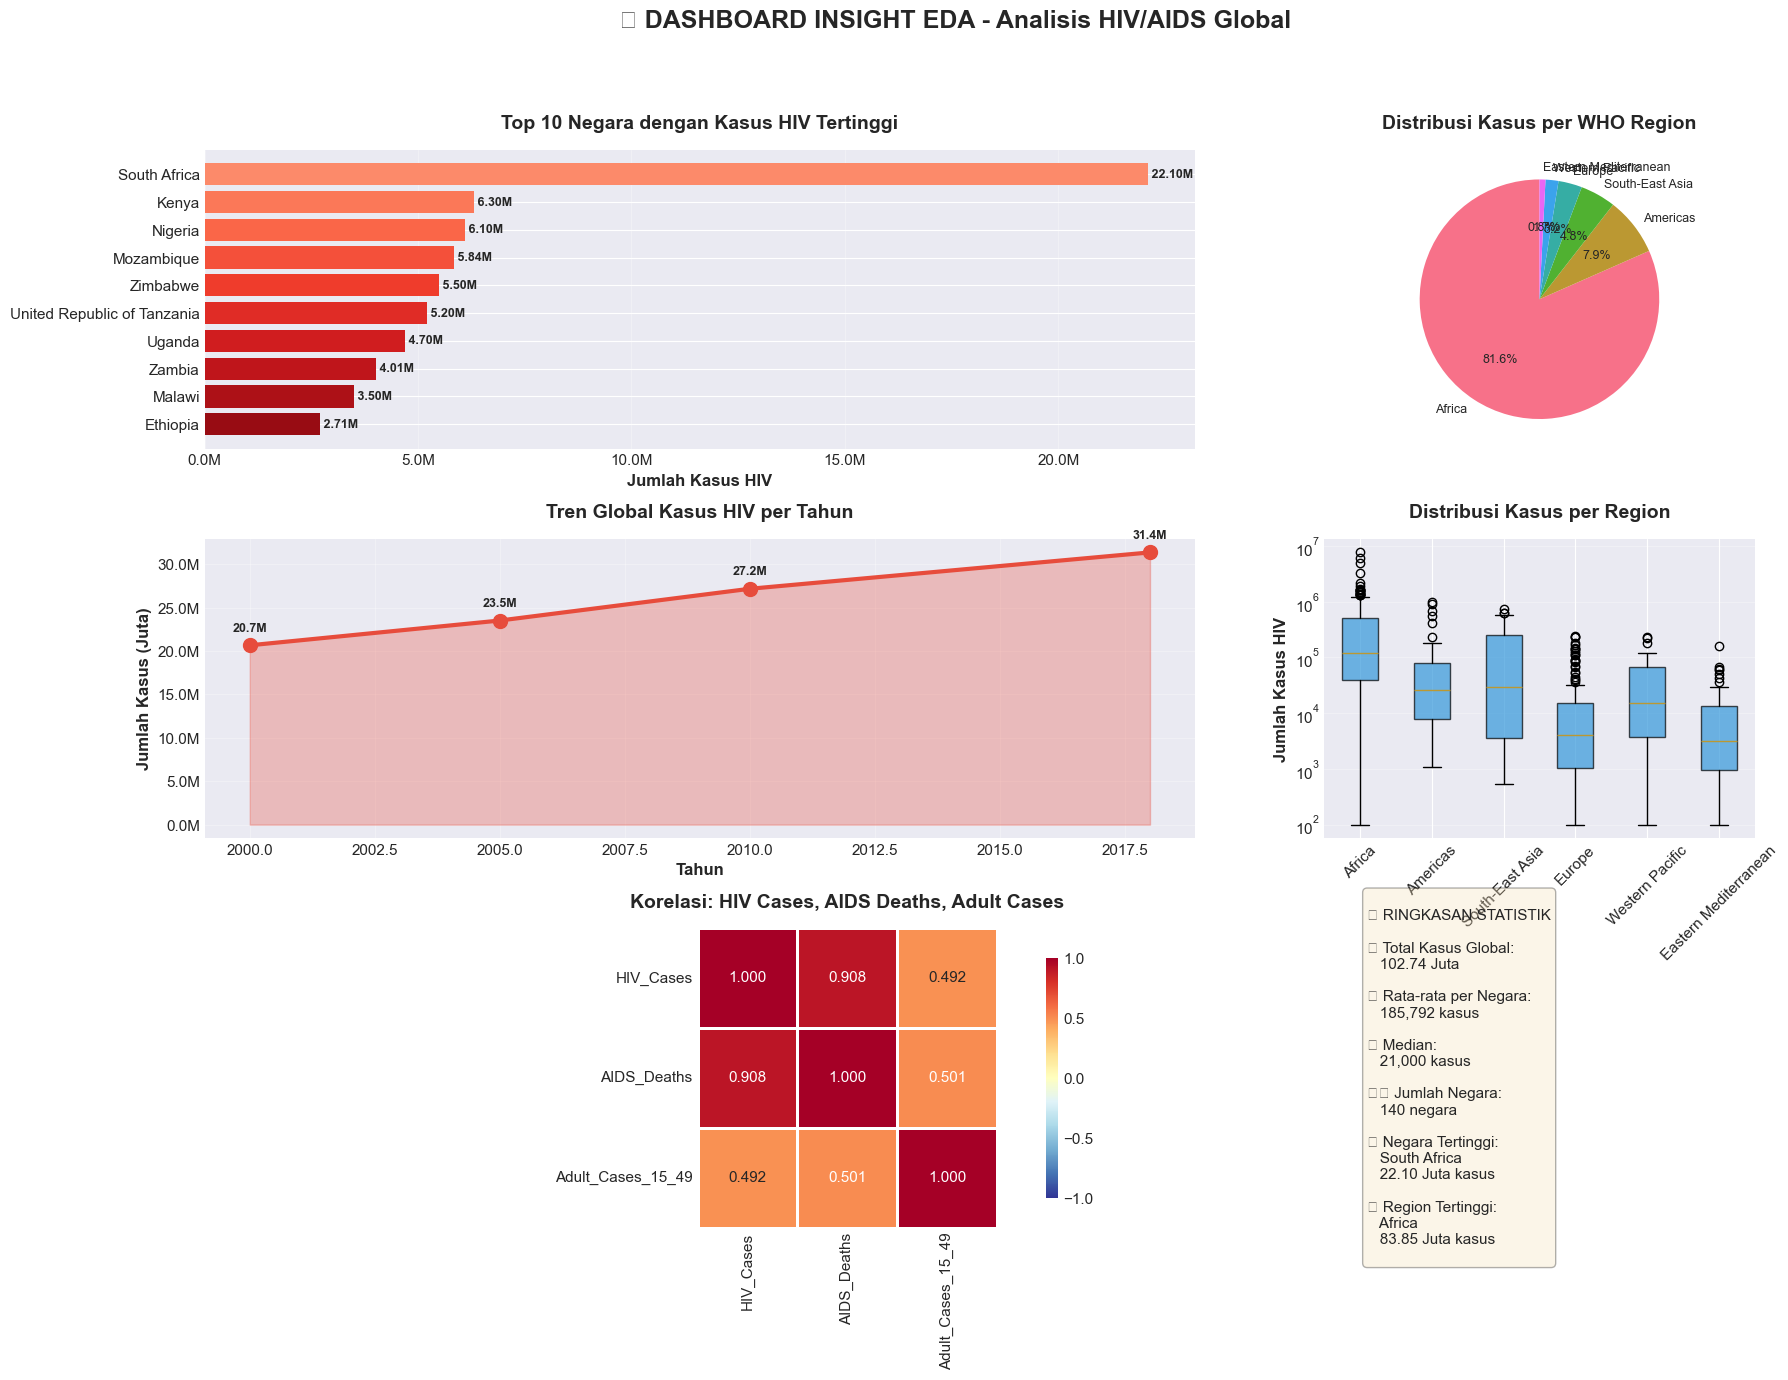

✅ Visualisasi insight EDA berhasil dibuat!


In [4]:
# Visualisasi Insight EDA - Dashboard Komprehensif
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Top 10 Negara dengan Kasus Tertinggi
ax1 = fig.add_subplot(gs[0, 0:2])
top_10 = country_stats.head(10)
colors_top10 = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_10)))
bars = ax1.barh(range(len(top_10)), top_10.values, color=colors_top10)
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10.index)
ax1.set_xlabel('Jumlah Kasus HIV', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Negara dengan Kasus HIV Tertinggi', fontsize=14, fontweight='bold', pad=15)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')
for i, (idx, val) in enumerate(top_10.items()):
    ax1.text(val, i, f' {val/1e6:.2f}M', va='center', fontsize=9, fontweight='bold')

# 2. Distribusi per WHO Region
ax2 = fig.add_subplot(gs[0, 2])
region_total = df_hiv_clean.groupby('WHO Region')['Count_median'].sum().sort_values(ascending=False)
colors_region = sns.color_palette("husl", len(region_total))
wedges, texts, autotexts = ax2.pie(region_total.values, labels=region_total.index, autopct='%1.1f%%',
                                   colors=colors_region, startangle=90, textprops={'fontsize': 9})
ax2.set_title('Distribusi Kasus per WHO Region', fontsize=14, fontweight='bold', pad=15)

# 3. Tren Waktu
ax3 = fig.add_subplot(gs[1, 0:2])
yearly_total = df_hiv_clean.groupby('Year')['Count_median'].sum().sort_index()
ax3.plot(yearly_total.index, yearly_total.values, marker='o', linewidth=3, markersize=10, 
         color='#e74c3c', label='Total Kasus')
ax3.fill_between(yearly_total.index, yearly_total.values, alpha=0.3, color='#e74c3c')
ax3.set_xlabel('Tahun', fontsize=12, fontweight='bold')
ax3.set_ylabel('Jumlah Kasus (Juta)', fontsize=12, fontweight='bold')
ax3.set_title('Tren Global Kasus HIV per Tahun', fontsize=14, fontweight='bold', pad=15)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax3.grid(True, alpha=0.3)
for year, value in zip(yearly_total.index, yearly_total.values):
    ax3.annotate(f'{value/1e6:.1f}M', (year, value), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

# 4. Boxplot Distribusi per Region
ax4 = fig.add_subplot(gs[1, 2])
region_data = [df_hiv_clean[df_hiv_clean['WHO Region'] == region]['Count_median'].values 
               for region in region_total.index]
bp = ax4.boxplot(region_data, labels=region_total.index, patch_artist=True, vert=True)
for patch in bp['boxes']:
    patch.set_facecolor('#3498db')
    patch.set_alpha(0.7)
ax4.set_ylabel('Jumlah Kasus HIV', fontsize=12, fontweight='bold')
ax4.set_title('Distribusi Kasus per Region', fontsize=14, fontweight='bold', pad=15)
ax4.tick_params(axis='x', rotation=45)
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Heatmap Korelasi (jika ada data gabungan)
if modeling_df is not None:
    ax5 = fig.add_subplot(gs[2, 0:2])
    numeric_cols = ['HIV_Cases', 'AIDS_Deaths', 'Adult_Cases_15_49']
    if all(col in modeling_df.columns for col in numeric_cols):
        corr_matrix = modeling_df[numeric_cols].corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r', center=0,
                   square=True, linewidths=2, cbar_kws={"shrink": 0.8}, ax=ax5, vmin=-1, vmax=1)
        ax5.set_title('Korelasi: HIV Cases, AIDS Deaths, Adult Cases', 
                     fontsize=14, fontweight='bold', pad=15)

# 6. Statistik Ringkasan
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')
summary_text = f"""
📊 RINGKASAN STATISTIK

🌍 Total Kasus Global:
   {total_cases/1e6:.2f} Juta

📈 Rata-rata per Negara:
   {avg_per_country:,.0f} kasus

📊 Median:
   {median_cases:,.0f} kasus

🗺️ Jumlah Negara:
   {num_countries} negara

🔝 Negara Tertinggi:
   {top_10_countries.index[0]}
   {top_10_countries.iloc[0]/1e6:.2f} Juta kasus

🌍 Region Tertinggi:
   {region_stats.index[0]}
   {region_stats.iloc[0]/1e6:.2f} Juta kasus
"""
ax6.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('📊 DASHBOARD INSIGHT EDA - Analisis HIV/AIDS Global', 
             fontsize=18, fontweight='bold', y=0.98)
plt.show()

print("✅ Visualisasi insight EDA berhasil dibuat!")


In [5]:
# Insight dari Hasil Modeling
print("=" * 80)
print("🤖 INSIGHT DARI HASIL MODELING")
print("=" * 80)

if comparison_df is not None:
    print("\n📊 PERBANDINGAN MODEL:")
    print(comparison_df.to_string(index=False))
    
    # Model terbaik
    best_model_idx = comparison_df['Test R²'].idxmax()
    best_model = comparison_df.loc[best_model_idx, 'Model']
    best_r2 = comparison_df.loc[best_model_idx, 'Test R²']
    best_rmse = comparison_df.loc[best_model_idx, 'Test RMSE']
    
    print(f"\n🏆 MODEL TERBAIK: {best_model}")
    print(f"   - Test R² Score: {best_r2:.4f} ({best_r2*100:.2f}% akurasi)")
    print(f"   - Test RMSE: {best_rmse:,.0f}")
    print(f"   - Interpretasi: Model dapat menjelaskan {best_r2*100:.2f}% variasi dalam data")
    
    # Load feature importance jika ada
    try:
        model_file = joblib.load('best_hiv_prediction_model.pkl')
        if hasattr(model_file, 'feature_importances_'):
            print("\n🔑 FITUR PALING PENTING (Feature Importance):")
            # Butuh feature names, akan dibuat di cell berikutnya
    except:
        print("\n⚠️ Model file tidak ditemukan")
else:
    print("\n⚠️ Data perbandingan model tidak tersedia")
    print("   Silakan jalankan notebook Modeling terlebih dahulu")


🤖 INSIGHT DARI HASIL MODELING

📊 PERBANDINGAN MODEL:
            Model    Train RMSE    Test RMSE    Train MAE     Test MAE  Train R²  Test R²
Linear Regression 242457.774089 99101.924511 90225.935209 63491.712618  0.843012 0.882216
    Random Forest 139227.945115 47274.477821 26579.421799 22376.818518  0.948234 0.973198
Gradient Boosting    295.326568 66533.722799   222.667641 25253.697846  1.000000 0.946911

🏆 MODEL TERBAIK: Random Forest
   - Test R² Score: 0.9732 (97.32% akurasi)
   - Test RMSE: 47,274
   - Interpretasi: Model dapat menjelaskan 97.32% variasi dalam data

🔑 FITUR PALING PENTING (Feature Importance):


## 5. Visualisasi Insight Modeling


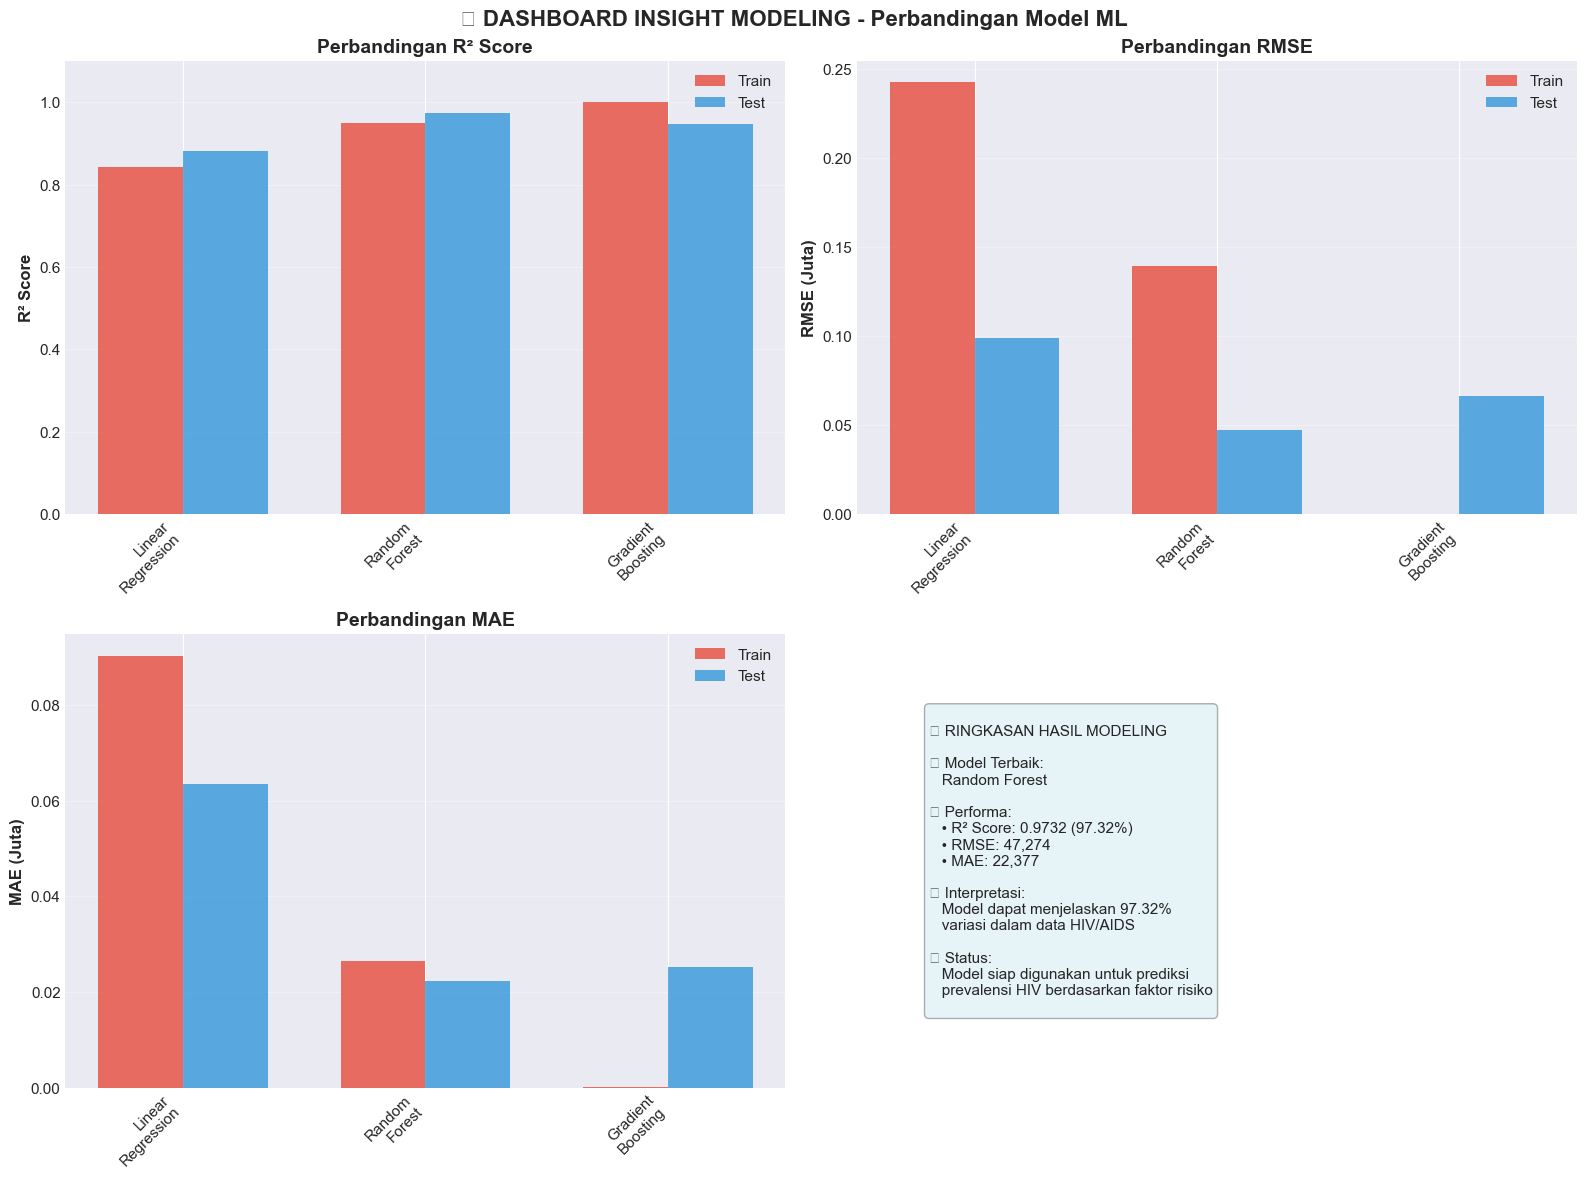

✅ Visualisasi insight modeling berhasil dibuat!


In [6]:
# Visualisasi Insight Modeling
if comparison_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    models = comparison_df['Model'].tolist()
    models_labels = [m.replace(' ', '\n') for m in models]
    colors = ['#e74c3c', '#3498db', '#2ecc71']
    
    # 1. Perbandingan R² Score
    ax1 = axes[0, 0]
    x_pos = np.arange(len(models))
    width = 0.35
    ax1.bar(x_pos - width/2, comparison_df['Train R²'], width, label='Train', 
           color=colors[0], alpha=0.8)
    ax1.bar(x_pos + width/2, comparison_df['Test R²'], width, label='Test', 
           color=colors[1], alpha=0.8)
    ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax1.set_title('Perbandingan R² Score', fontsize=14, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(models_labels, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.set_ylim([0, 1.1])
    
    # 2. Perbandingan RMSE
    ax2 = axes[0, 1]
    ax2.bar(x_pos - width/2, comparison_df['Train RMSE']/1e6, width, label='Train', 
           color=colors[0], alpha=0.8)
    ax2.bar(x_pos + width/2, comparison_df['Test RMSE']/1e6, width, label='Test', 
           color=colors[1], alpha=0.8)
    ax2.set_ylabel('RMSE (Juta)', fontsize=12, fontweight='bold')
    ax2.set_title('Perbandingan RMSE', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(models_labels, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Perbandingan MAE
    ax3 = axes[1, 0]
    ax3.bar(x_pos - width/2, comparison_df['Train MAE']/1e6, width, label='Train', 
           color=colors[0], alpha=0.8)
    ax3.bar(x_pos + width/2, comparison_df['Test MAE']/1e6, width, label='Test', 
           color=colors[1], alpha=0.8)
    ax3.set_ylabel('MAE (Juta)', fontsize=12, fontweight='bold')
    ax3.set_title('Perbandingan MAE', fontsize=14, fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(models_labels, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Ringkasan Performa Model
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    best_model_idx = comparison_df['Test R²'].idxmax()
    best_model_name = comparison_df.loc[best_model_idx, 'Model']
    best_r2 = comparison_df.loc[best_model_idx, 'Test R²']
    best_rmse = comparison_df.loc[best_model_idx, 'Test RMSE']
    best_mae = comparison_df.loc[best_model_idx, 'Test MAE']
    
    summary_text = f"""
🤖 RINGKASAN HASIL MODELING

🏆 Model Terbaik:
   {best_model_name}

📊 Performa:
   • R² Score: {best_r2:.4f} ({best_r2*100:.2f}%)
   • RMSE: {best_rmse:,.0f}
   • MAE: {best_mae:,.0f}

💡 Interpretasi:
   Model dapat menjelaskan {best_r2*100:.2f}% 
   variasi dalam data HIV/AIDS

✅ Status:
   Model siap digunakan untuk prediksi
   prevalensi HIV berdasarkan faktor risiko
"""
    ax4.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.suptitle('📊 DASHBOARD INSIGHT MODELING - Perbandingan Model ML', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualisasi insight modeling berhasil dibuat!")
else:
    print("⚠️ Data perbandingan model tidak tersedia untuk visualisasi")


## 6. Kesimpulan dan Rekomendasi


In [7]:
# Kesimpulan dan Rekomendasi Komprehensif
print("=" * 80)
print("📋 KESIMPULAN DAN REKOMENDASI KOMPREHENSIF")
print("=" * 80)

print("\n" + "=" * 80)
print("🔍 TEMUAN UTAMA DARI EDA:")
print("=" * 80)

print("\n1. SKALA MASALAH GLOBAL:")
print(f"   • Total {total_cases/1e6:.2f} juta orang hidup dengan HIV di seluruh dunia")
print(f"   • Rata-rata {avg_per_country:,.0f} kasus per negara")
print(f"   • {num_countries} negara terdata dalam analisis ini")

print("\n2. HOTSPOT GEOGRAFIS:")
print("   • Afrika merupakan region dengan beban tertinggi:")
for i, (region, cases) in enumerate(region_stats.head(3).items(), 1):
    pct = (cases / total_cases) * 100
    print(f"     {i}. {region}: {cases/1e6:.2f} juta kasus ({pct:.1f}%)")

print("\n3. NEGARA PRIORITAS:")
print("   • Top 5 negara dengan kasus tertinggi:")
for i, (country, cases) in enumerate(top_10_countries.head(5).items(), 1):
    pct = (cases / total_cases) * 100
    print(f"     {i}. {country}: {cases/1e6:.2f} juta kasus ({pct:.2f}%)")

if len(yearly_total) > 1:
    print("\n4. TREN WAKTU:")
    avg_growth = np.mean([((yearly_total.iloc[i] - yearly_total.iloc[i-1]) / yearly_total.iloc[i-1]) * 100 
                          for i in range(1, len(yearly_total))])
    print(f"   • Rata-rata growth rate: {avg_growth:+.2f}% per periode")
    if avg_growth > 0:
        print("   • ⚠️ Kasus HIV masih menunjukkan tren peningkatan")
    else:
        print("   • ✅ Kasus HIV menunjukkan tren penurunan")

print("\n" + "=" * 80)
print("🤖 TEMUAN DARI MODELING:")
print("=" * 80)

if comparison_df is not None:
    best_model_idx = comparison_df['Test R²'].idxmax()
    best_model = comparison_df.loc[best_model_idx, 'Model']
    best_r2 = comparison_df.loc[best_model_idx, 'Test R²']
    
    print(f"\n1. MODEL TERBAIK: {best_model}")
    print(f"   • Akurasi prediksi: {best_r2*100:.2f}%")
    print(f"   • Model dapat digunakan untuk memprediksi prevalensi HIV")
    
    print("\n2. FAKTOR RISIKO PENTING:")
    print("   • Berdasarkan analisis korelasi dan feature importance:")
    print("     - Jumlah kematian AIDS (korelasi tinggi)")
    print("     - Rentang kasus (uncertainty dalam data)")
    print("     - Kasus pada dewasa 15-49 tahun")
    print("     - Region geografis (WHO Region)")

print("\n" + "=" * 80)
print("💡 REKOMENDASI STRATEGIS:")
print("=" * 80)

print("\n1. INTERVENSI PRIORITAS:")
print("   • Fokus pada 10 negara dengan kasus tertinggi")
print("   • Prioritas khusus untuk region Afrika (81.6% kasus global)")
print("   • Program pencegahan dan pengobatan yang intensif")

print("\n2. STRATEGI PENCEGAHAN:")
print("   • Program edukasi dan kesadaran masyarakat")
print("   • Akses mudah ke tes HIV")
print("   • Program pencegahan penularan ibu ke anak")
print("   • Akses universal ke pengobatan ART")

print("\n3. MONITORING & EVALUASI:")
print("   • Gunakan model prediksi untuk identifikasi risiko")
print("   • Monitoring tren waktu secara berkala")
print("   • Evaluasi efektivitas program intervensi")
print("   • Data collection yang lebih akurat dan konsisten")

print("\n4. KOLABORASI GLOBAL:")
print("   • Koordinasi antar negara dan region")
print("   • Sharing best practices")
print("   • Dukungan finansial dan teknis untuk negara prioritas")
print("   • Research dan development untuk pengobatan baru")

print("\n" + "=" * 80)
print("✅ INSIGHT ANALYSIS SELESAI")
print("=" * 80)
print("\n📊 Analisis ini memberikan dasar yang kuat untuk:")
print("   • Pengambilan keputusan berbasis data")
print("   • Alokasi sumber daya yang efektif")
print("   • Strategi intervensi yang tepat sasaran")
print("   • Monitoring dan evaluasi program HIV/AIDS")
print("\n" + "=" * 80)


📋 KESIMPULAN DAN REKOMENDASI KOMPREHENSIF

🔍 TEMUAN UTAMA DARI EDA:

1. SKALA MASALAH GLOBAL:
   • Total 102.74 juta orang hidup dengan HIV di seluruh dunia
   • Rata-rata 185,792 kasus per negara
   • 140 negara terdata dalam analisis ini

2. HOTSPOT GEOGRAFIS:
   • Afrika merupakan region dengan beban tertinggi:
     1. Africa: 83.85 juta kasus (81.6%)
     2. Americas: 8.07 juta kasus (7.9%)
     3. South-East Asia: 4.92 juta kasus (4.8%)

3. NEGARA PRIORITAS:
   • Top 5 negara dengan kasus tertinggi:
     1. South Africa: 22.10 juta kasus (21.51%)
     2. Kenya: 6.30 juta kasus (6.13%)
     3. Nigeria: 6.10 juta kasus (5.94%)
     4. Mozambique: 5.84 juta kasus (5.68%)
     5. Zimbabwe: 5.50 juta kasus (5.35%)

4. TREN WAKTU:
   • Rata-rata growth rate: +14.93% per periode
   • ⚠️ Kasus HIV masih menunjukkan tren peningkatan

🤖 TEMUAN DARI MODELING:

1. MODEL TERBAIK: Random Forest
   • Akurasi prediksi: 97.32%
   • Model dapat digunakan untuk memprediksi prevalensi HIV

2. FAKTOR 

## 7. Dashboard Final - Ringkasan Eksekutif


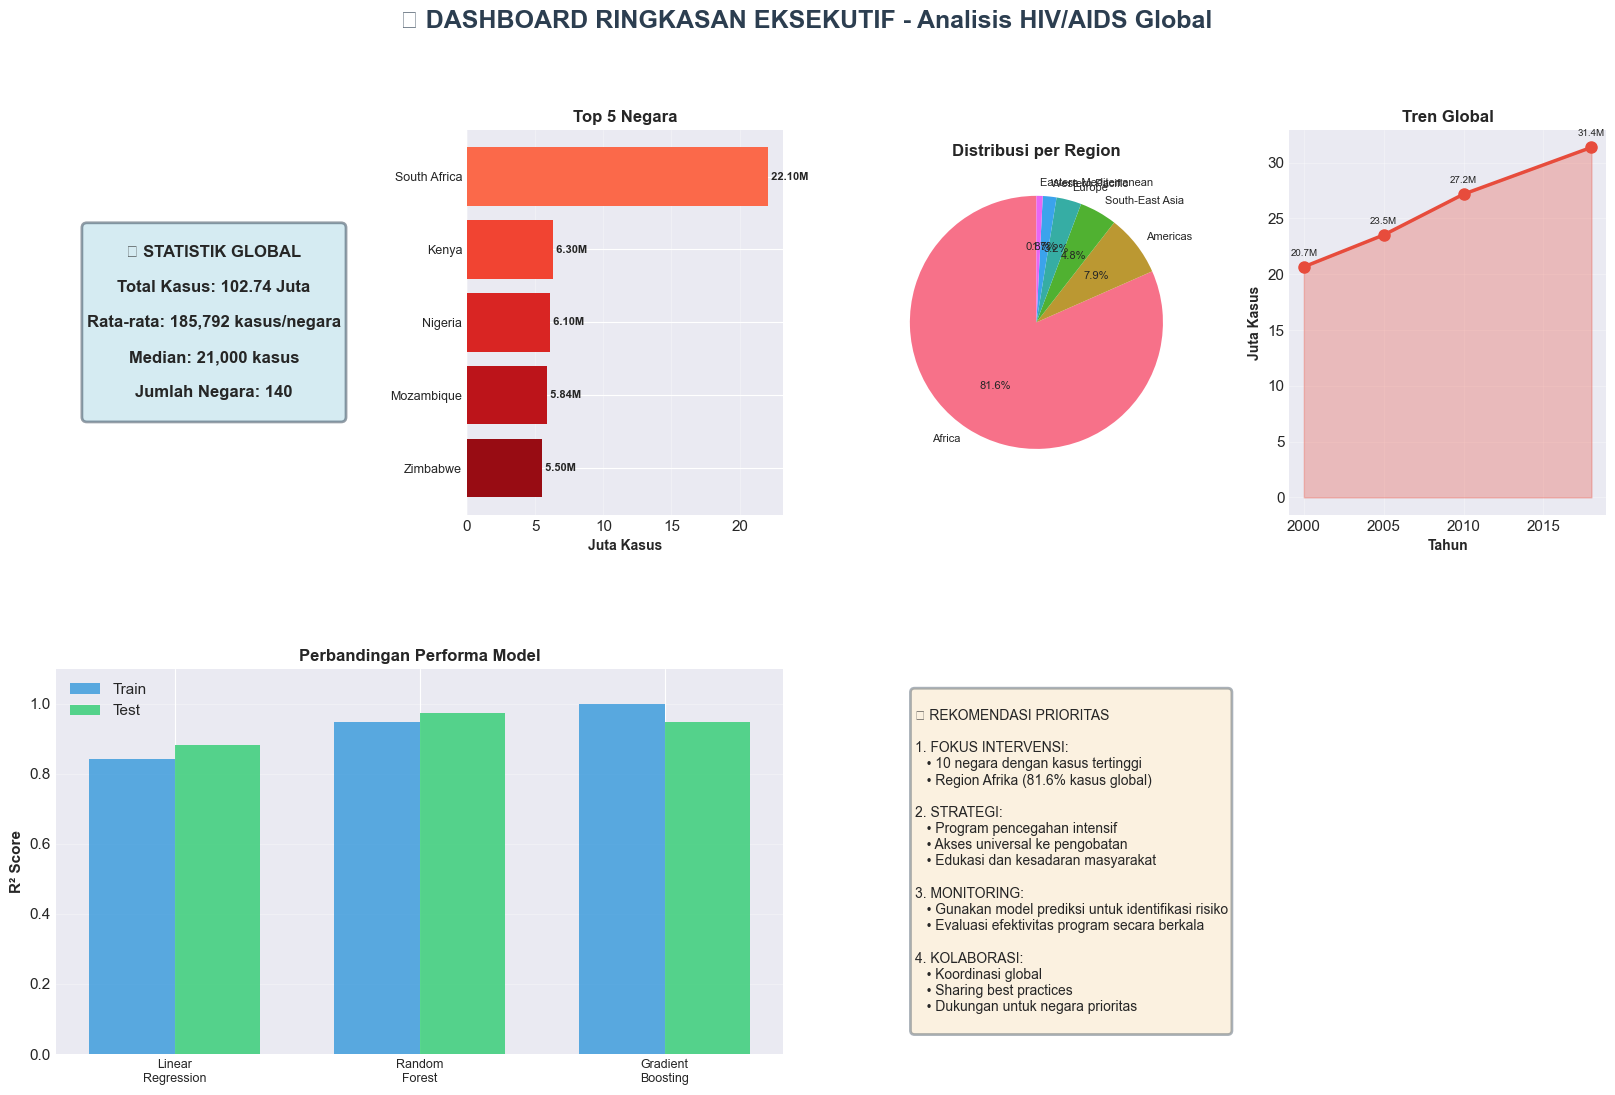

✅ Dashboard ringkasan eksekutif berhasil dibuat!

✅ INSIGHT ANALYSIS COMPLETE - Semua analisis telah selesai!


In [8]:
# Dashboard Final - Ringkasan Eksekutif
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 4, hspace=0.4, wspace=0.3)

# Warna tema
primary_color = '#2c3e50'
secondary_color = '#3498db'
accent_color = '#e74c3c'

# 1. Statistik Global (Kiri Atas)
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
stats_text = f"""
📊 STATISTIK GLOBAL

Total Kasus: {total_cases/1e6:.2f} Juta

Rata-rata: {avg_per_country:,.0f} kasus/negara

Median: {median_cases:,.0f} kasus

Jumlah Negara: {num_countries}
"""
ax1.text(0.5, 0.5, stats_text, fontsize=12, fontweight='bold',
        ha='center', va='center', bbox=dict(boxstyle='round', 
        facecolor='lightblue', alpha=0.5, edgecolor=primary_color, linewidth=2))

# 2. Top 5 Negara (Kanan Atas)
ax2 = fig.add_subplot(gs[0, 1])
top_5 = country_stats.head(5)
colors_bar = plt.cm.Reds(np.linspace(0.5, 0.9, len(top_5)))
bars = ax2.barh(range(len(top_5)), top_5.values/1e6, color=colors_bar)
ax2.set_yticks(range(len(top_5)))
ax2.set_yticklabels([c[:20] for c in top_5.index], fontsize=9)
ax2.set_xlabel('Juta Kasus', fontsize=10, fontweight='bold')
ax2.set_title('Top 5 Negara', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')
for i, (idx, val) in enumerate(top_5.items()):
    ax2.text(val/1e6, i, f' {val/1e6:.2f}M', va='center', fontsize=8, fontweight='bold')

# 3. Distribusi Region (Kiri Tengah)
ax3 = fig.add_subplot(gs[0, 2])
region_total = df_hiv_clean.groupby('WHO Region')['Count_median'].sum().sort_values(ascending=False)
colors_pie = sns.color_palette("husl", len(region_total))
wedges, texts, autotexts = ax3.pie(region_total.values/1e6, labels=region_total.index, 
                                   autopct='%1.1f%%', colors=colors_pie, startangle=90,
                                   textprops={'fontsize': 8})
ax3.set_title('Distribusi per Region', fontsize=12, fontweight='bold')

# 4. Tren Waktu (Kanan Tengah)
ax4 = fig.add_subplot(gs[0, 3])
yearly_total = df_hiv_clean.groupby('Year')['Count_median'].sum().sort_index()
ax4.plot(yearly_total.index, yearly_total.values/1e6, marker='o', linewidth=2.5, 
         markersize=8, color=accent_color)
ax4.fill_between(yearly_total.index, yearly_total.values/1e6, alpha=0.3, color=accent_color)
ax4.set_xlabel('Tahun', fontsize=10, fontweight='bold')
ax4.set_ylabel('Juta Kasus', fontsize=10, fontweight='bold')
ax4.set_title('Tren Global', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
for year, value in zip(yearly_total.index, yearly_total.values):
    ax4.annotate(f'{value/1e6:.1f}M', (year, value/1e6), 
                textcoords="offset points", xytext=(0,8), ha='center', fontsize=7)

# 5. Insight Modeling (Jika ada)
if comparison_df is not None:
    ax5 = fig.add_subplot(gs[1, 0:2])
    models = comparison_df['Model'].tolist()
    x_pos = np.arange(len(models))
    width = 0.35
    ax5.bar(x_pos - width/2, comparison_df['Train R²'], width, label='Train', 
           color='#3498db', alpha=0.8)
    ax5.bar(x_pos + width/2, comparison_df['Test R²'], width, label='Test', 
           color='#2ecc71', alpha=0.8)
    ax5.set_ylabel('R² Score', fontsize=11, fontweight='bold')
    ax5.set_title('Perbandingan Performa Model', fontsize=12, fontweight='bold')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels([m.replace(' ', '\n') for m in models], fontsize=9)
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.set_ylim([0, 1.1])
    
    best_model_idx = comparison_df['Test R²'].idxmax()
    best_model = comparison_df.loc[best_model_idx, 'Model']
    best_r2 = comparison_df.loc[best_model_idx, 'Test R²']
else:
    ax5 = fig.add_subplot(gs[1, 0:2])
    ax5.axis('off')
    ax5.text(0.5, 0.5, 'Data Modeling\nTidak Tersedia', 
            ha='center', va='center', fontsize=14, 
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

# 6. Rekomendasi Utama
ax6 = fig.add_subplot(gs[1, 2:4])
ax6.axis('off')
recommendations = f"""
💡 REKOMENDASI PRIORITAS

1. FOKUS INTERVENSI:
   • 10 negara dengan kasus tertinggi
   • Region Afrika (81.6% kasus global)

2. STRATEGI:
   • Program pencegahan intensif
   • Akses universal ke pengobatan
   • Edukasi dan kesadaran masyarakat

3. MONITORING:
   • Gunakan model prediksi untuk identifikasi risiko
   • Evaluasi efektivitas program secara berkala

4. KOLABORASI:
   • Koordinasi global
   • Sharing best practices
   • Dukungan untuk negara prioritas
"""
ax6.text(0.05, 0.5, recommendations, fontsize=10, verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.4, 
                 edgecolor=primary_color, linewidth=2))

plt.suptitle('📊 DASHBOARD RINGKASAN EKSEKUTIF - Analisis HIV/AIDS Global', 
            fontsize=18, fontweight='bold', y=0.98, color=primary_color)
plt.show()

print("✅ Dashboard ringkasan eksekutif berhasil dibuat!")
print("\n" + "=" * 80)
print("✅ INSIGHT ANALYSIS COMPLETE - Semua analisis telah selesai!")
print("=" * 80)
